# Imports

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/')
from helpers_locs_to_home import time_2_date
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tkr
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report

import pickle
import re;pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''');new_geo=[]
import warnings
import seaborn as sns

import geopandas as gpd
from geopandas import GeoDataFrame
from geopandas import sjoin

Reminder: Not running filters based on users.db


## New Stuff

In [2]:
dgeo=pd.read_csv(header=None,sep="\t",filepath_or_buffer="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/2014-2015_locs.txt")
dgeo.columns=["usr","time","lat","lon","text"]
fechas,days,hours,minutes,seconds,years,months=time_2_date(dgeo.time)
dgeo['day']=days;dgeo['hour']=hours;dgeo['min']=minutes;dgeo['sec']=seconds
dgeo['year']=years;dgeo['month']=months;dgeo['fecha']=fechas
dgeo=dgeo.drop(labels="time",axis=1)
print("Number of geolocated tweets during 2014-2015... %d geolocations"%dgeo.shape[0])
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])
locs=[Point((lon,lat)) for lon,lat in zip(dgeo.lon,dgeo.lat)]
dgeo_france=dgeo[[france.contains(geo_pt) for geo_pt in locs]]
print("Number of geolocated tweets during 2014-2015 in France... %d geolocations"%dgeo_france.shape[0])

A Jupyter Widget


Number of geolocated tweets during 2014-2015... 2601875 geolocations
Number of geolocated tweets during 2014-2015 in France... 2218611 geolocations


In [3]:
from tqdm import tqdm_notebook as tqdmn
import geopandas as gpd
dgeo_france["geometry"]=[Point(x.lon,x.lat) for it,x in tqdmn(dgeo_france[["lon","lat"]].iterrows())]
dgeo_france=gpd.GeoDataFrame(dgeo_france)

A Jupyter Widget

In [4]:
def naive_most_freq(geopandas_usr):
    geopandas_usr=geopandas_usr.reset_index().drop("index",axis=1)
    polys_visited=["(%.3f,%.3f)"%(x[0],x[1]) for x in geopandas_usr[["lat","lon"]].values]
    selected=Counter(polys_visited).most_common(1)[0][0]
    idx_mode=polys_visited.index(selected)
    return idx_mode,geopandas_usr.iloc[idx_mode]["geometry"]

def go_through_home_candidates(dic_gpd,select_home_loc):
    dic_exam={}
    for usr,gpd in tqdmn(dic_gpd.items()):
        idx,loc=select_home_loc(gpd)
        if idx is None:
            continue
        dic_exam.setdefault(usr,gpd.iloc[idx])
    return dic_exam

def get_gini_for_userset(user_ses_dic):
    home_most_freq_all=go_through_home_candidates(user_ses_dic,naive_most_freq)
    dic_all_users_insee={usr:{"suppl_info":home_most_freq_all[usr]} 
                         for usr in (home_most_freq_all.keys()) }
    #
    usr2ses=pd.DataFrame([[k,v["suppl_info"]["geometry"]]
                          for k,v in dic_all_users_insee.items()],
                         columns=["usr","geometry"]).dropna(how="any")
    return usr2ses

In [5]:
geo_usrs={}
for it,row in tqdmn(dgeo_france.iterrows()):
    geo_usrs.setdefault(row.usr,[])
    geo_usrs[row.usr].append(row)

for usr,val in tqdmn(geo_usrs.items()):
    geo_usrs[usr]=pd.DataFrame(val,columns=list(dgeo_france.columns))

from datetime import datetime
usr2ses_ori=get_gini_for_userset(geo_usrs)#[["year","month","fecha","hour","minu","sec"]]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [7]:
usr2ses_ori=GeoDataFrame(usr2ses_ori)
usr2ses_ori.crs={'init': 'epsg:4326'}
from tqdm import tqdm as tqdmn
geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/communes.geojson"
df_arro = gpd.read_file(geo_file)
df_arro.crs={'init': 'epsg:4326'}

In [8]:
print("aight")
geo_usr2ses_ori=sjoin(usr2ses_ori,df_arro, how="inner", op='within')

aight


In [11]:
geo_arr_ori=(geo_usr2ses_ori.code.value_counts()).to_frame()
geo_arr_ori.reset_index(inplace=True)
geo_arr_ori.columns=['Codes','nb_usrs']
geo_arr_ori.head()

,Codes,nb_usrs
0,75101,6372
1,59350,1014
2,31555,954
3,69382,828
4,06088,737


In [15]:
import xlrd
path = "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/ensemble.xls"
workbook = xlrd.open_workbook(path)
worksheet = workbook.sheet_by_name("Communes")
offset = 6

rows = []
for i, row in enumerate(range(worksheet.nrows)):
    if i <= offset:  # (Optionally) skip headers
        continue
    r = []
    for j, col in enumerate(range(worksheet.ncols)):
        r.append(worksheet.cell_value(i, j))
    rows.append(r)

    
d_exc=pd.DataFrame(rows[1:],columns=rows[0])
d_exc['Codes']=[u+'%03d'%int(v) for u,v in zip(d_exc['Code département'],d_exc['Code commune'])]
d_exc.head()

,Code région,Nom de la région,Code département,Code arrondissement,Code canton,Code commune,Nom de la commune,Population municipale,Population comptée à part,Population totale,Codes
0,82,Rhône-Alpes,01,2,08,001,L' Abergement-Clémenciat,767.0,13.0,780.0,01001
1,82,Rhône-Alpes,01,1,01,002,L' Abergement-de-Varey,236.0,4.0,240.0,01002
2,82,Rhône-Alpes,01,1,01,004,Ambérieu-en-Bugey,14359.0,529.0,14888.0,01004
3,82,Rhône-Alpes,01,2,22,005,Ambérieux-en-Dombes,1635.0,31.0,1666.0,01005
4,82,Rhône-Alpes,01,1,04,006,Ambléon,108.0,6.0,114.0,01006


In [16]:
d_insee=d_exc[['Codes','Population totale']]
#d_insee['Population totale']=(d_insee['Population totale']+0.0)/sum(d_insee['Population totale'])
d_corr=pd.merge(d_insee,geo_arr_ori,on='Codes')
d_corr.head()


,Codes,Population totale,nb_usrs
0,01004,14888.0,6
1,01005,1666.0,1
2,01010,1127.0,1
3,01014,3534.0,4
4,01017,430.0,1


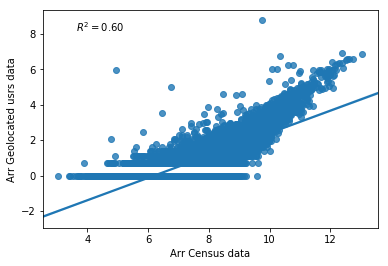

In [17]:
import seaborn as sns
import numpy as np
import scipy.stats as st
sns.regplot(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))
rsquare = st.pearsonr(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))[0]**2
plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')
plt.ylabel('Arr Geolocated usrs data')
plt.xlabel('Arr Census data')
plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
df = gpd.read_file(geo_file)
codes=[];names=[]
for point in tqdmn(usr2ses_ori.geometry):
    indi=list(map(lambda poly:poly.contains(point),df.geometry))
    res_code,res_name=(df.code[indi],df.nom[indi])
    if len(res_code)==0:
        code,name=(None,None)
    else:
        code,name=(list(res_code.to_dict().values())[0],list(res_name.to_dict().values())[0])
    codes.append(code);names.append(name)


usr2ses_ori['Codes']=codes
usr2ses_ori['Names']=names

import xlrd
path = "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/france-geojson/ensemble.xls"
workbook = xlrd.open_workbook(path)
worksheet = workbook.sheet_by_name("Communes")
offset = 6

rows = []
for i, row in enumerate(range(worksheet.nrows)):
    if i <= offset:  # (Optionally) skip headers
        continue
    r = []
    for j, col in enumerate(range(worksheet.ncols)):
        r.append(worksheet.cell_value(i, j))
    rows.append(r)

    
d_exc=pd.DataFrame(rows[1:],columns=rows[0])
d_exc['Codes']=[u+'%03d'%int(v) for u,v in zip(d_exc['Code département'],d_exc['Code commune'])]
d_exc.head()

geo_arr_ori=(usr2ses_ori.Codes.value_counts()).to_frame()
geo_arr_ori.reset_index(inplace=True)
geo_arr_ori.columns=['Codes','nb_usrs']
geo_arr_ori.head()

d_insee=d_exc[['Codes','Population totale']]
#d_insee['Population totale']=(d_insee['Population totale']+0.0)/sum(d_insee['Population totale'])
d_corr=pd.merge(d_insee,geo_arr_ori,on='Codes')
d_corr.head()

import numpy as np
import scipy.stats as st
rsquare = st.pearsonr(np.log(d_corr['Population totale']),np.log(d_corr['nb_usrs']))[0]**2
print(rsquare)

In [6]:
import xlrd,json
def extract_xls_file(path,sheet_name,offset):
    workbook = xlrd.open_workbook(path)
    worksheet = workbook.sheet_by_name(sheet_name)
    rows = []
    for i, row in (enumerate(range(worksheet.nrows))):
        if i <= offset:  # (Optionally) skip headers
            continue
        r = []
        for j, col in enumerate(range(worksheet.ncols)):
            r.append(worksheet.cell_value(i, j))
        rows.append(r)
    return(pd.DataFrame(rows[1:],columns=rows[0]))

f0="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/iris_opendata/RFDM2010IRI.xls"
d_exc=extract_xls_file(f0,"Distribution_Ménages",5)


f2="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/iris_opendata/BASE_TD_FILO_DEC_IRIS_2013.xls"
d_filo_dec_iris=extract_xls_file(f2,"IRIS_DEC",4)

import geopandas as gpd
geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/iris_opendata/shapefile_iris/contours-iris-2016.geojson"
with open(geo_file) as f:
    arro_data=json.load(f)

print("arro done")
df = gpd.read_file(geo_file)
codes=[];names=[]
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])

d_iris=df[[france.contains(geo_pt) if geo_pt else False for geo_pt in (df.geometry)]]
d_iris['IRIS']=d_iris.code_iris
dec_pop_iris=pd.merge(d_iris, d_exc, on='IRIS')
dec_income_iris=pd.merge(d_iris, d_filo_dec_iris, on='IRIS')

arro done


('(48.946,2.491)', 1)

In [21]:
dgeo_france.head().reset_index().drop("index",axis=1)

,usr,lat,lon,text,day,hour,min,sec,year,month,fecha,geometry
0,2296639897,48.945839,2.491264,#JPNGRE 3-0 pr le #JPN,3,15,44,3,2014,06,19,POINT (2.4912635419 48.9458390389)
1,360954534,49.303493,5.863804,"Mon père a une nouvelle lubie, m'appeler ""ma p...",3,15,44,3,2014,06,19,POINT (5.863804 49.303493)
2,190311280,43.552704,7.023194,C'est la fête 💶💶💶,3,15,44,3,2014,06,19,POINT (7.023194 43.552704)
3,1498428090,48.673666,2.289129,Putain je viens de me brûler la langue 🙊🙊🙊🙊,3,15,44,4,2014,06,19,POINT (2.289129 48.673666)
4,289953393,48.865732,2.386827,#tweetlocalisation Denfert Rochereau,3,15,44,4,2014,06,19,POINT (2.386827 48.865732)


In [25]:
def naive_most_freq(geopandas_usr):
    geopandas_usr=geopandas_usr.reset_index().drop("index",axis=1)
    polys_visited=["(%.3f,%.3f)"%(x[0],x[1]) for x in geopandas_usr[["lat","lon"]].values]
    selected=Counter(polys_visited).most_common(1)[0][0]
    idx_mode=polys_visited.index(selected)
    return idx_mode,geopandas_usr.iloc[idx_mode]["geometry"]

def go_through_home_candidates(dic_gpd,select_home_loc):
    dic_exam={}
    for usr,gpd in tqdmn(dic_gpd.items()):
        idx,loc=select_home_loc(gpd)
        if idx is None:
            continue
        dic_exam.setdefault(usr,gpd.iloc[idx])
    return dic_exam

def get_gini_for_userset(user_ses_dic):
    home_most_freq_all=go_through_home_candidates(user_ses_dic,naive_most_freq)
    dic_all_users_insee={usr:{"suppl_info":home_most_freq_all[usr]} 
                         for usr in (home_most_freq_all.keys()) }
    #
    usr2ses=pd.DataFrame([[k,v["suppl_info"]["geometry"],v["suppl_info"]["DEC_D113"],
                           v["suppl_info"]["DEC_MED13"],v["suppl_info"]["DEC_D913"],v["suppl_info"]["DEC_GI13"]]
                          for k,v in dic_all_users_insee.items()],
                         columns=["usr","geom","insee_iris_lowe",
                                  "insee_iris_med","insee_iris_sup","gini"]).dropna(how="any")
    return usr2ses

In [23]:
from geopandas import sjoin
usrs_with_iris_income = sjoin(dgeo_france, dec_income_iris, how="inner", op='within')

In [26]:
from tqdm import tqdm

usrs_with_iris_info_dic={}
for it,row in tqdmn(usrs_with_iris_income.iterrows()):
    usrs_with_iris_info_dic.setdefault(row.usr,[])
    usrs_with_iris_info_dic[row.usr].append(row)

for usr,val in tqdmn(usrs_with_iris_info_dic.items()):
    usrs_with_iris_info_dic[usr]=pd.DataFrame(val,columns=list(usrs_with_iris_income.columns))
    
from datetime import datetime
ori_usr2ses_ori=get_gini_for_userset(usrs_with_iris_info_dic)#[["year","month","fecha","hour","minu","sec"]]

A Jupyter Widget

In [36]:
Counter(ori_usr2ses_ori.geom.astype(str)).most_common(10)

[('POINT (3.07158865 50.62897405)', 500),
 ('POINT (1.4329006 43.60075845)', 469),
 ('POINT (5.40527395 43.29430915)', 459),
 ('POINT (-0.58622995 44.86373785)', 422),
 ('POINT (-1.56073945 47.2381615)', 403),
 ('POINT (3.8742675 43.61039585)', 340),
 ('POINT (7.76220805 48.5693064)', 310),
 ('POINT (7.25302235 43.70302075)', 281),
 ('POINT (-1.6883315 48.11577645)', 273),
 ('POINT (-0.37195855 49.1846344)', 217)]

In [29]:
np.average(ori_usr2ses_ori.gini)

0.3736658082656559

In [48]:
ori_usr2ses_ori["geometry"]=ori_usr2ses_ori.geom

In [49]:
usrs_with_iris_pop_income = sjoin(GeoDataFrame(ori_usr2ses_ori), dec_pop_iris, how="inner", op='within')

In [30]:
ori_usr2ses_ori.head()

,usr,geom,insee_iris_lowe,insee_iris_med,insee_iris_sup,gini
0,2296639897,POINT (1.215625 49.272943),350.0,8590.0,22398.0,0.448699
1,1230244579,POINT (2.4912635419 48.9458390389),5752.0,18000.0,33576.0,0.328834
2,2209176489,POINT (2.419187 48.987652),5948.0,18202.0,34742.0,0.347300
3,14184499,POINT (2.4912635419 48.9458390389),5752.0,18000.0,33576.0,0.328834
4,187926568,POINT (2.4912635419 48.9458390389),5752.0,18000.0,33576.0,0.328834


In [51]:
usrs_with_iris_pop_income.agg("")

,usr,geom,insee_iris_lowe,insee_iris_med,insee_iris_sup,gini,geometry,index_right,iris,nom_iris,...,RFMD110,RFMD210,RFMD310,RFMD410,RFMD610,RFMD710,RFMD810,RFMD910,RFMRD10,RFMET10
0,2296639897,POINT (1.215625 49.272943),350.0,8590.0,22398.0,0.448699,POINT (1.215625 49.272943),6161,0103,Est,...,2110,7973.5,11613,14659,21095,25737,30931,41620,19.7,16466.5
31645,447074518,POINT (1.21669 49.273052),350.0,8590.0,22398.0,0.448699,POINT (1.21669 49.273052),6161,0103,Est,...,2110,7973.5,11613,14659,21095,25737,30931,41620,19.7,16466.5
31646,114030711,POINT (1.223511 49.27529699999999),350.0,8590.0,22398.0,0.448699,POINT (1.223511 49.27529699999999),6161,0103,Est,...,2110,7973.5,11613,14659,21095,25737,30931,41620,19.7,16466.5
31647,1699519292,POINT (1.217572 49.269158),350.0,8590.0,22398.0,0.448699,POINT (1.217572 49.269158),6161,0103,Est,...,2110,7973.5,11613,14659,21095,25737,30931,41620,19.7,16466.5
31648,1036012754,POINT (1.217658 49.270082),350.0,8590.0,22398.0,0.448699,POINT (1.217658 49.270082),6161,0103,Est,...,2110,7973.5,11613,14659,21095,25737,30931,41620,19.7,16466.5


In [30]:
np.average(ori_usr2ses_ori.gini)

0.37354592047664126

In [42]:
dgeo_france.head()

,usr,lat,lon,text,day,hour,min,sec,year,month,fecha,geometry
1,2296639897,48.945839,2.491264,#JPNGRE 3-0 pr le #JPN,3,15,44,3,2014,06,19,POINT (2.4912635419 48.9458390389)
2,360954534,49.303493,5.863804,"Mon père a une nouvelle lubie, m'appeler ""ma p...",3,15,44,3,2014,06,19,POINT (5.863804 49.303493)
3,190311280,43.552704,7.023194,C'est la fête 💶💶💶,3,15,44,3,2014,06,19,POINT (7.023194 43.552704)
4,1498428090,48.673666,2.289129,Putain je viens de me brûler la langue 🙊🙊🙊🙊,3,15,44,4,2014,06,19,POINT (2.289129 48.673666)
5,289953393,48.865732,2.386827,#tweetlocalisation Denfert Rochereau,3,15,44,4,2014,06,19,POINT (2.386827 48.865732)


In [39]:
Counter(ori_usr2ses_ori.geom.astype(str)).most_common(10)

[]

In [64]:
dec_pop_iris["IRIS"].shape

(12630,)

In [66]:
x=pd.merge(usrs_with_iris_pop_income.groupby("IRIS")["usr"].agg("count").reset_index(),dec_pop_iris,on="IRIS")

In [86]:
np.sum(pop_iris[~np.isnan()])

TypeError: only integer scalar arrays can be converted to a scalar index

## Old Stuff

In [ ]:

#####################                RAW DATA             #########################

##### Profiles
data_prof_14=pd.read_csv(
    "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/icdm18/issues/icdm_geousers_profile_14.txt",
    sep="\t",header=-1,
    names=["id","time","lat","lon","geo_pt","service","profile","follows","friends",
                                     "nb urls","loc_name","geo_type"],
    index_col=False)

fechas,days,hours,minutes,seconds,years,months=time_2_date(data_prof_14.time)
data_prof_14['day']=days;data_prof_14['hour']=hours
data_prof_14['min']=minutes;data_prof_14['sec']=seconds
data_prof_14['year']=years;data_prof_14['month']=months
data_prof_14['fecha']=fechas

##### Users in France
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],
                [-4.9658203125,42.3585439175]])
locs_prof=[Point((float(lon),float(lat))) 
           for lon,lat in zip(data_prof_14.lon,data_prof_14.lat)]

dgeo_prof_france_14=data_prof_14[[france.contains(geo_pt) for geo_pt in locs_prof]]
print("Number of geolocated tweets during 2014-2015... %d geolocations"%
      dgeo_prof_france_14.shape[0])
print("Number of geolocated tweets during 2014-2015 in France... %d geolocations"%
      dgeo_prof_france_14.shape[0])

dgeo_prof_france_14["geometry"]=[Point(x.lon,x.lat) for it,x in tqdmn(dgeo_prof_france_14[["lon","lat"]].iterrows())]
dgeo_prof_france_14=GeoDataFrame(dgeo_prof_france_14)
dgeo_prof_france_14.crs = {'init': 'epsg:4326'}

##### Text of geolocated users
usr_tweet_text=pd.read_csv(
    "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/tweets/all_geolocated_users.csv",
    sep=';',header=0,
)

##### Fake Locations
nb_rep_thresh=10
pre_fake_locs=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/txt_files/fake_locs.txt",names=["pre"])
fake_locs=[]
for x in pre_fake_locs.pre:
    try:
        lat,lon=float(x.split("-")[0]),float(x.split("-")[-1])
    except:
        continue
    if len(x)==3:fake_locs.append(str((lat,-lon)))
    else: fake_locs.append(str((lat,lon)))

dec_prec=3
fake_locs=list(set(fake_locs))
pre_fake=Counter([(round(x[0],dec_prec),round(x[1],dec_prec))
                  for x in  dgeo_prof_france_14[["lat","lon"]].values])
set_toher_fakes=set([x for x in pre_fake if pre_fake[x]>nb_rep_thresh])

In [8]:
import xlrd,json
def extract_xls_file(path,sheet_name,offset):
    workbook = xlrd.open_workbook(path)
    worksheet = workbook.sheet_by_name(sheet_name)
    rows = []
    for i, row in (enumerate(range(worksheet.nrows))):
        if i <= offset:  # (Optionally) skip headers
            continue
        r = []
        for j, col in enumerate(range(worksheet.ncols)):
            r.append(worksheet.cell_value(i, j))
        rows.append(r)
    return(pd.DataFrame(rows[1:],columns=rows[0]))


f2="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/iris_opendata/BASE_TD_FILO_DEC_IRIS_2013.xls"
d_filo_dec_iris=extract_xls_file(f2,"IRIS_DEC",4)

import geopandas as gpd
geo_file="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/iris_opendata/shapefile_iris/contours-iris-2016.geojson"
with open(geo_file) as f:
    arro_data=json.load(f)

print("arro done")
df = gpd.read_file(geo_file)
codes=[];names=[]
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])

d_iris=df[[france.contains(geo_pt) if geo_pt else False for geo_pt in (df.geometry)]]
d_iris['IRIS']=d_iris.code_iris
dec_income_iris=pd.merge(d_iris, d_filo_dec_iris, on='IRIS')

arro done


In [9]:
from geopandas import sjoin
usrs_with_iris_income = sjoin(dgeo_prof_france_14, dec_income_iris,how="inner", op='within')

In [34]:
ori_usrs_with_SES_info_dic={}
for it,row in tqdmn(usrs_with_iris_income.iterrows()):
    ori_usrs_with_SES_info_dic.setdefault(row.id,[])
    ori_usrs_with_SES_info_dic[row.id].append(row)

for usr,val in tqdmn(ori_usrs_with_SES_info_dic.items()):
    ori_usrs_with_SES_info_dic[usr]=pd.DataFrame(val,columns=list(usrs_with_iris_income.columns))
inter={}
for k,v in tqdmn(ori_usrs_with_SES_info_dic.items()):
    v=v.rename(index=str, columns={"min": "minu","nb urls":"text"})
    inter[k]=v

ori_usrs_with_SES_info_dic=inter
del inter

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

# Load Relevant Data

In [9]:
import pickle
usrs_with_SES_info_dic=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/usrs_with_SES_info_dic.p",
                                        "rb"))
inter={}
for k,v in tqdmn(usrs_with_SES_info_dic.items()):
    v=v.rename(index=str, columns={"min": "minu","nb urls":"text"})
    inter[k]=v

usrs_with_SES_info_dic=inter
del inter

HBox(children=(IntProgress(value=0, max=127614), HTML(value='')))

In [10]:
dec_prec=5
nb_rep_thresh=10
pre_fake_locs=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/geoloc/txt_files/fake_locs.txt",
                          names=["pre"])
fake_locs=[]
for x in pre_fake_locs.pre:
    try:
        lat,lon=round(float(x.split("-")[0]),dec_prec),round(float(x.split("-")[-1]),dec_prec)
    except:
        continue
    if len(x)==3:
        fake_locs.append(str((round(lat,dec_prec),-round(lon,dec_prec))))
    else:
        fake_locs.append(str((round(lat,dec_prec),round(lon,dec_prec))))

set_toher_fakes=list(set(fake_locs))

# Filters

__why getting good results without the filters?__

In [11]:
max_km_var=10
max_km_per_h=120
nb_mini_locs=5
nb_min_crazy=20
thresh_rate=3

dic_locs_reals,d_locs_fast,d_locs_vars,dic_mar,dic_dist,dic_speed,pre_home=fast_get_repr_location(
    dic_locs=usrs_with_SES_info_dic,
    max_km_var=max_km_var,
    max_km_per_h=max_km_per_h,
    nb_mini_locs=nb_mini_locs,
    nb_min_crazy=nb_min_crazy)

#new_dic_real,activ_static_usrs=remove_active_static_usrs(dic_real=dic_locs_reals,pandas_version=0)
new_dic_real_normal_activ,hyper_active_usrs=remove_hyperactive_usrs(dic_locs_reals,pandas_version=0,thresh_rate=thresh_rate)
new_dic_real_normal_social,hyper_social_usrs_home=remove_hyper_social_usrs(dic_real=new_dic_real_normal_activ)

print("Number of users before filtering... %d"%len(usrs_with_SES_info_dic.keys()))
print("Users going too fast... %d"%len(d_locs_fast))
print("Users too variable ... %d"%len(d_locs_vars))
print("Weather bots ... %d"%len(dic_mar))
print("Real users with more than %d locations ...%d"%(nb_mini_locs,len(dic_locs_reals)))
print("Users posting 2 consecutive tweets in less than 2 secs  ... %d"%len(hyper_active_usrs))
print("Users with too many followers/friends ... %d"%len(hyper_social_usrs_home))
print("Final nb of users  %d"%len(new_dic_real_normal_social))

HBox(children=(IntProgress(value=0, max=127614), HTML(value='')))

HBox(children=(IntProgress(value=0, max=53787), HTML(value='')))


Number of users before filtering... 127614
Users going too fast... 0
Users too variable ... 1099
Weather bots ... 818
Real users with more than 5 locations ...53787
Users posting 2 consecutive tweets in less than 2 secs  ... 13814
Users with too many followers/friends ... 0
Final nb of users  39973


In [52]:
from datetime import datetime
ori_usr2ses_ori=get_gini_for_userset(ori_usrs_with_SES_info_dic)#[["year","month","fecha","hour","minu","sec"]]

A Jupyter Widget

In [55]:
np.average(ori_usr2ses_ori.gini)

0.3727800190426334

In [ ]:
np.average(ori_usr2ses_ori.DEC_GI13)

In [ ]:
usr2ses_ori=get_gini_for_userset(usrs_with_SES_info_dic)
usr2ses_locs_reals=get_gini_for_userset(dic_locs_reals)
usr2ses_normal_activ=get_gini_for_userset(new_dic_real_normal_activ)
usr2ses_real_normal_social=get_gini_for_userset(new_dic_real_normal_social)
usr2ses_final=get_gini_for_userset(new_dic_real_normal_social,min_t=5,min_d=1)

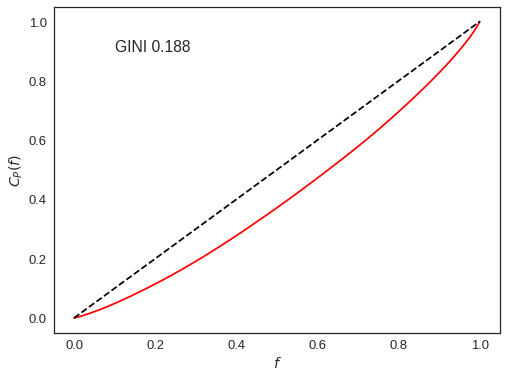

In [56]:
f_income_all_homes,cpf_income_all_homes=yannick_plots(usr2ses_final.insee_iris_med)
import matplotlib.pyplot as plt
import seaborn as sns
# Log-Log Income Distribution
plt.figure(figsize=(8,6))
sns.set(font_scale=1.3)
sns.set_style('white')

# Cumulative Income Distribution
plt.plot(f_income_all_homes,cpf_income_all_homes,"red")
plt.plot([0,1],[0,1],"k--")
plt.xlabel(r"$f$");
plt.ylabel(r"$C_P(f)$");
plt.text(x=0.1,y=0.9,
         s="GINI %.3f"%(gini(f_income_all_homes,cpf_income_all_homes)));
plt.show()

In [ ]:
Counter([(x.lat,x.lon) for x in usr2ses_ori["geom"].values]).most_common()

In [ ]:
homogeneous_usrs=np.array([bool(np.all(np.array([x,y,z,t]))) or bool(1-np.all(np.array([x,y,z,t]) )) 
                  for x,y,z,t in zip(ses_insee_class,ses_iris_class_lowe,ses_iris_class_med,ses_iris_class_sup)])

# Helpers

## Location Helpers

In [9]:
uk = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'
from pyproj import transform,Proj

def proj_arr(points,proj_to):
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj,outproj,x[1],x[0])
    return np.array(list(map(func, points)))

def take_most_frequent_thresh(geopandas_usr,min_times=5,min_days=1):
    polys_visited=list(geopandas_usr.IRIS)
    time_of_visit=[datetime(int(row.year),int(row.month),int(row.fecha),
                            int(row.hour),int(row["min"]),int(row.sec))
                   for it,row in geopandas_usr.iterrows()]
    locat_mode=Counter(polys_visited).most_common(1)[0][0]
    nb_times=Counter(polys_visited).most_common(1)[0][1]
    inter_idx=np.where([x==locat_mode for x in polys_visited])[0].tolist()
    time_diff=[time_of_visit[i] for i in inter_idx]
    if nb_times>=min_times and (max(time_diff)-min(time_diff)).days>=min_days:
        idx_mode=polys_visited.index(locat_mode)
        return idx_mode,geopandas_usr.iloc[idx_mode]["geometry"]
    else:
        return None,None

def get_check_in_rate_margin_most_freq(geopandas_usr):
    polys_visited=list(geopandas_usr.idINSPIRE)
    inter=Counter(polys_visited).most_common(2)
    if len(inter)<2:
        return None,None,None,None,None
    locat_mode,sec_locat_mode=inter
    idx_mode,idx_mode_sec=polys_visited.index(locat_mode[0]),polys_visited.index(sec_locat_mode[0])
    return (idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]],
            idx_mode_sec,geopandas_usr.iloc[idx_mode_sec][["lat","lon"]],
           ((locat_mode[1]+0.0-sec_locat_mode[1])/(sec_locat_mode[1]+locat_mode[1])))

def take_most_frequent_night_thresh(geopandas_usr,start=21,stop=6) :
    polys_visited=(geopandas_usr.idINSPIRE)
    polys_visited_night=polys_visited[(geopandas_usr.hour>=start)|(geopandas_usr.hour<stop)]
    if len(polys_visited_night)==0:
        return None,None
    locat_mode=Counter(polys_visited_night).most_common(1)[0][0]
    idx_mode=list(polys_visited).index(locat_mode)
    return idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]]

def get_distance_matrix(geopandas_usr):
    x = np.array(geopandas_usr[["lat","lon"]]).astype(float).tolist()
    y=proj_arr(x,uk)
    ztree = cKDTree(y)
    z = ztree.sparse_distance_matrix(ztree,1e6,p=2).todense()
    return z

def distance_to_home(geopandas_usr,select_home_loc,args):
    idx,loc=select_home_loc(geopandas_usr,*args)
    if idx is None:
        return None,None,None
    mat_dist=get_distance_matrix(geopandas_usr)
    return mat_dist[idx,:].tolist()[0],list(geopandas_usr.day),list(geopandas_usr.hour)

def go_through_home_candidates(dic_gpd,select_home_loc):
    dic_exam={}
    for usr,gpd in tqdmn(dic_gpd.items()):
        idx,loc=select_home_loc(gpd)
        if idx is None:
            continue
        dic_exam.setdefault(usr,gpd.iloc[idx])
    return dic_exam

def go_through_geol_users(dic_gpd,select_home_loc,args,outlier_lim=6e4):
    dic_per_day={k:np.zeros(24) for k in range(7)}
    dic_nb_per_day={k:np.zeros(24) for k in range(7)}
    dic_exam={}
    loss=[]
    for usr,gpd in tqdmn(dic_gpd.items()):
        dic_exam.setdefault(usr,[])
        dists,days,hours=distance_to_home(gpd,select_home_loc,args)
        new_dists=np.array(dists)
        if dists is None:
            continue
        loss.append(1-(np.sum([new_dists<outlier_lim])+0.0)/len(dists) )
        dists=new_dists[new_dists<outlier_lim]
        for dist,day,hour in zip(dists,days,hours):
            dic_exam[usr].append(dist)
            dic_per_day[day][hour]+=dist
            dic_nb_per_day[day][hour]+=1
    dic_day={}
    for k,v in dic_per_day.items():
        dic_day[k]=(v/dic_nb_per_day[k])/100
    return dic_day,dic_exam,loss

## Cython: Redefine "polygon contains point" function from shapely

Redefine "polygon contains point" function from shapely

In [ ]:
%load_ext cython

In [ ]:
%%cython -l geos_c -L/home/jlevyabi/seacabo/geoanaconda/anaconda3/lib -I/home/jlevyabi/seacabo/geoanaconda/anaconda3/include -a

import cython
cimport cpython.array

import numpy as np
cimport numpy as np

cdef extern from "geos_c.h":
    ctypedef void *GEOSContextHandle_t
    ctypedef struct GEOSGeometry
    char GEOSContains_r(GEOSContextHandle_t, const GEOSGeometry*, const GEOSGeometry*) nogil
    
cdef GEOSContextHandle_t get_geos_context_handle():
    # Note: This requires that lgeos is defined, so needs to be imported as:
    from shapely.geos import lgeos
    cdef np.uintp_t handle = lgeos.geos_handle
    return <GEOSContextHandle_t>handle


@cython.boundscheck(False)
@cython.wraparound(False)
def contains_cy_insee(np.int64_t[:] array_usrs, np.int64_t[:]array_insee ):
    
    cdef Py_ssize_t idx
    cdef unsigned int n = array_usrs.size
    cdef unsigned int n_geo = array_insee.size
    cdef np.ndarray[np.uint8_t, ndim=2, cast=True] result = np.empty([n,n_geo],dtype=np.uint8)

    cdef GEOSContextHandle_t geos_handle
    cdef GEOSGeometry *geom1
    cdef GEOSGeometry *geom2
    cdef np.uintp_t geos_geom_usrs
    cdef np.uintp_t geos_geom_insee

    geos_h = get_geos_context_handle()
    for idx in xrange(n):
        for idx_geos in xrange(n_geo):
            geos_geom_usrs = array_usrs[idx]
            geom2 = <GEOSGeometry *>geos_geom_usrs
            geos_geom_insee = array_insee[idx_geos]
            geom1 = <GEOSGeometry *> geos_geom_insee
            
            # Put the result of whether the point is "contained" by the
            # prepared geometry into the result array. 
            result[idx][idx_geos] = <np.uint8_t> GEOSContains_r(geos_h, geom1, geom2)
            #GEOSGeom_destroy_r(geos_h, geom2)

    return result.view(dtype=np.bool)

In [ ]:
def my_pt2poly(usr_df,country_dic,set_keys):
    usr_info=[];prec=2;step=10**(-prec);vals=[-step,0,step]
    test=[]
    map_prec = lambda x: str(round(x,prec))
    for it,usr in tqdmn(usr_df.iterrows()):
        us_posx,us_posy=usr.geometry.centroid.bounds[:2]  
        usr_geom=usr.geometry._geom
        keys=(set([(map_prec(us_posy+yval),map_prec(us_posx+xval))
              for xval in vals for yval in vals])).intersection(set_keys)
        pre_df_of_concern=[country_dic[key]
                       for key in keys if country_dic[key].shape[0]>0]
        df_of_concern=[y._geom 
                       for x in pre_df_of_concern for y in x.geometry]
        df_ilocs_concern=[y
                       for x in pre_df_of_concern for y in x["Unnamed: 0"]]
        if len(df_of_concern)==0:
            test.append(None)
            continue
        #insee_to_check = pd.concat(df_of_concern)
        geom_to_check = df_of_concern#np.array([x._geom for x in (insee_to_check.geometry)])
        assignments=(contains_cy_insee(np.array([usr_geom]), np.array(geom_to_check)))
        to_check=np.where(assignments)
        _,poly=to_check
        if len(poly)==0:
            test.append(None)
        else:
            test.append(df_ilocs_concern[poly[0]])
    return test